# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 0
#! source activate tensorflow

# IF YOU RUN THIS PAGE FOR THE FIRST TIME : 

# START HERE

# OTHERWISE, YOU CAN START BELOW TO AVOID FETCHING ALL THE DATA AGAIN

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from time import time
from sklearn.preprocessing import MinMaxScaler

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

In [3]:
ROOTPATH = os.getcwd()
path = os.path.join(ROOTPATH, 'Data')

if not os.path.exists(path):
    os.makedirs(path)


# 1) This first part is only accessing in a list all the tickers in our fund, via a csv

In [4]:
# In the file IBB_holdings.csv, the tickers are sorted by descending weigths as of 5-Feb-18
# The file contains a lot of information about the fund IBB as of 5-Feb-18, which can be imported via row[i], i being the column you want
# For now we only import the first column, tickers.

if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c >= 11:
                list_tickers.append(row[0].split(',')[0])
            c+=1
else:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c >= 11:
                list_tickers.append(row[0].split(',')[0])
            c+=1
            
list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")

# 2) We now want to download the data of all tickers as dataframes

In [5]:
# Setting up the variables

start_date = '2016-01-01'
end_date = '2018-01-01'


nb_tickers = len(list_tickers)
list_dataframes=[None]*(nb_tickers)

In [6]:
#On Yahoo
still_missing = nb_tickers
passages = 0

while still_missing > 0 and passages < 100:
    passages += 1
    print("harvest number " , passages)
    for i in range (nb_tickers ):
        if type(list_dataframes[i]) == type(None):   
            symbol = list_tickers[i]
            try:
                df = web.DataReader(symbol, 'yahoo' , start_date ,end_date)
                list_dataframes[i] = df
                still_missing -= 1
            except:
                print("Oops!  That was no valid ticker.  Try again... "+list_tickers[i])

harvest number  1
Oops!  That was no valid ticker.  Try again... AIMT
Oops!  That was no valid ticker.  Try again... AKAO
Oops!  That was no valid ticker.  Try again... ARRY
Oops!  That was no valid ticker.  Try again... ASND
Oops!  That was no valid ticker.  Try again... ATNX
Oops!  That was no valid ticker.  Try again... BCRX
Oops!  That was no valid ticker.  Try again... BIIB
Oops!  That was no valid ticker.  Try again... BOLD
Oops!  That was no valid ticker.  Try again... CLXT
Oops!  That was no valid ticker.  Try again... COLL
Oops!  That was no valid ticker.  Try again... FOLD
Oops!  That was no valid ticker.  Try again... FPRX
Oops!  That was no valid ticker.  Try again... GLYC
Oops!  That was no valid ticker.  Try again... GTHX
Oops!  That was no valid ticker.  Try again... ICPT
Oops!  That was no valid ticker.  Try again... ILMN
Oops!  That was no valid ticker.  Try again... INVA
Oops!  That was no valid ticker.  Try again... IRWD
Oops!  That was no valid ticker.  Try again...

# 3) Finally, we can download in a new folder all this information for future use, to avoid downloading them from the web again

In [7]:
#Download of the dataframes as as many csv's (for now)

for i in range (nb_tickers ):  
    file_name = 'csv_' + list_tickers[i] + '_from_' + start_date + '_to_' + end_date + ".csv"
    string = path + '\\' + file_name
    list_dataframes[i].to_csv(string , sep=',')

# 4) This program is not (yet) collecting the two tickers that are not equities : BLKFDS and USD

# 5) We also need a benchmark

In [8]:
# Here the benchmark is NASDAQ Biotechnology index 
symbol='^NBI'
benchmark1 = web.DataReader(symbol, 'yahoo' , start_date ,end_date)

In [9]:
# Here the benchmark is iShares Nasdaq Biotechnology ETF 
symbol='IBB'
benchmark2 = web.DataReader(symbol, 'yahoo' , start_date ,end_date)

# 6) Now we need rate of returns

In [10]:
df_ror_1 = benchmark1['High'].pct_change()
df_ror_2 = benchmark2['High'].pct_change()

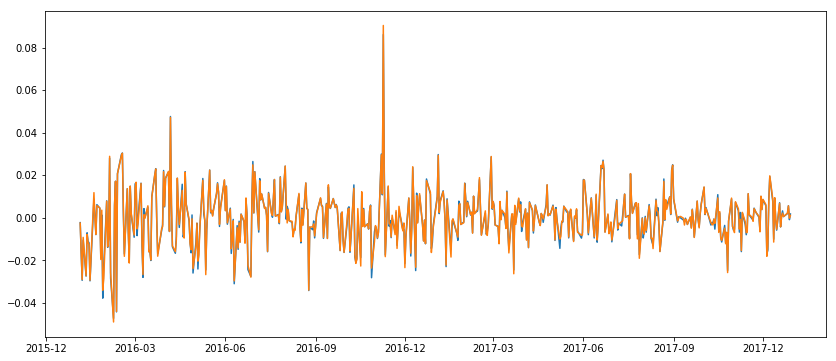

In [11]:
# Both benchmarks should have similar rate of returns, though they have different prices
plt.plot(df_ror_1)
plt.hold
plt.plot(df_ror_2)
plt.show;

In [12]:
def rateOfReturnWeekly(df,column):
    # Column has to be a column of the dataframe (ie 'Open','AdjClose')
    
    # Making sure dataframe is well sorted
    df_sorted = df.sort_index( ascending = True )
    

    # So far gives daily as shift = 1!
    shift = 1
    df_shifted = df_sorted.shift(shift)
    rate_of_returns = (df_sorted - df_shifted) / df_shifted
    rate_of_returns = rate_of_returns.drop(rate_of_returns.index[0])

    return rate_of_returns

# 7) Function to add noise to a dataframe (a new dataframe will be created)

In [13]:
def add_noise_2(df_origin, tick, mean = 0, std = 0.005):
    noise = []
    
    # Creating the noise
    for i in range(len(df_origin)):
        x = np.exp(np.random.normal(mean,std))
        noise.append(x)
        
    df_modified = df_origin.copy()
    df_modified['Adj Close'] = df_modified['Adj Close'].multiply(noise)
    
    file_name = 'csv_' + tick + '_B_' + str(mean) + '_' + str(std) + '_from_' + start_date + '_to_' + end_date + '.csv'
    string = path + file_name
    df_modified.to_csv(os.path.join(path,file_name), sep=',') 

# 8) Create all the new csv

In [14]:
"""
allFiles = glob.glob(path + "/csv" + "*.csv")


i=0
if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            if list_tickers[i] != 'SNDX':
                df = pd.read_csv(csvfile, index_col=None, header=0)
                add_noise_2(df,list_tickers[i],0,0.01)
                #add_noise_2(df,list_tickers[i],0,0.008)
                #add_noise_2(df,list_tickers[i],0,0.0003)
                #add_noise_2(df,list_tickers[i],0,0.002)
                #add_noise_2(df,list_tickers[i],0,0.0006)
            i=i+1
    
if computer == 1:    
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            if list_tickers[i] != 'SNDX':
                df = pd.read_csv(csvfile, index_col=None, header=0)
                add_noise_2(df,list_tickers[i],0,0.01)
                #add_noise_2(df,list_tickers[i],0,0.008)
                #add_noise_2(df,list_tickers[i],0,0.0003)
                #add_noise_2(df,list_tickers[i],0,0.002)
                #add_noise_2(df,list_tickers[i],0,0.0006)
            i=i+1
"""

'\nallFiles = glob.glob(path + "/csv" + "*.csv")\n\n\ni=0\nif computer == 0:\n    for file_ in allFiles:\n        with open(file_, \'r\') as csvfile:\n            if list_tickers[i] != \'SNDX\':\n                df = pd.read_csv(csvfile, index_col=None, header=0)\n                add_noise_2(df,list_tickers[i],0,0.01)\n                #add_noise_2(df,list_tickers[i],0,0.008)\n                #add_noise_2(df,list_tickers[i],0,0.0003)\n                #add_noise_2(df,list_tickers[i],0,0.002)\n                #add_noise_2(df,list_tickers[i],0,0.0006)\n            i=i+1\n    \nif computer == 1:    \n    for file_ in allFiles:\n        with open(file_, \'r\', encoding =\'mac_roman\') as csvfile:\n            if list_tickers[i] != \'SNDX\':\n                df = pd.read_csv(csvfile, index_col=None, header=0)\n                add_noise_2(df,list_tickers[i],0,0.01)\n                #add_noise_2(df,list_tickers[i],0,0.008)\n                #add_noise_2(df,list_tickers[i],0,0.0003)\n            

# IF YOU RUN THIS PAGE FOR THE SECOND TIME : 

# START HERE

# Are you on PC or MAC? pc = 0, mac = 1

In [71]:
computer = 0
#! source activate tensorflow

In [72]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time
from sklearn.preprocessing import MinMaxScaler

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

In [73]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

if not(ROOTPATH[-4:] == 'Data'):
    path = os.path.join(ROOTPATH, 'Data')
else:
    path = ROOTPATH

In [74]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

In [75]:
nb_tickers = len(list_tickers)
list_dataframes=[]


allFiles = glob.glob(path + "/csv" + "*.csv")
i = 0

if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
            i+=1

if computer == 1:
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
            i += 1
            
num_files = i
            
            
maxi = 0
length = 0
compt = 0
j = 0

for df in list_dataframes:
    if len(df)>maxi:
        maxi = len(df['Adj Close'])

data = np.array([np.zeros(maxi)]*(num_files)) 


for df in list_dataframes:
    arr = np.array(df['Adj Close'])
    if len(arr) == maxi and not df['Adj Close'].isnull().values.any():    
        minimum = np.min(arr)
        maximum = np.max(arr)
        arr = (arr - minimum) / (maximum - minimum)
        data[j] = arr
        j += 1
    else :
        compt += 1            
    

data = data[:-compt]  

#np.random.shuffle(data)   

train_set = data[:-50]
test_set = data[-50:-25]
validation_set = data[-25:]

In [76]:
len(data)

169

# 9) Set up Tensorboard

In [77]:
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

# 10) Set up the autoencoder

In [78]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [79]:
# Training Parameters
learning_rate = 0.001
num_steps = 300
batch_size = 10
lambd = 0.1

display_step = 100

# Network Parameters 

num_hidden_1 = 250 # 1st layer num features
num_input = 503 # 503 days considered


In [80]:
X = tf.placeholder("float", [None, num_input])
learning = tf.placeholder("float")
keep_prob = tf.placeholder(tf.float32) #gateway for dropout

In [81]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1],mean=0.0,
    stddev=1.0/np.sqrt(num_input))),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_1, num_input],mean=0.0,
    stddev=1.0/np.sqrt(num_hidden_1)))
}
biases = {
    'encoder_b1': tf.Variable(tf.zeros([num_hidden_1])),
    'decoder_b1': tf.Variable(tf.zeros([num_input])),
}

In [82]:
# Building the encoder
def encoder(x,dropout):
    # x = tf.nn.dropout(x, dropout)
    # Encoder Hidden layer with relu activation #1
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    return layer_1


# Building the decoder
def decoder(x, dropout):
    x = tf.nn.dropout(x, dropout)
    # Decoder Hidden layer with relu activation #1
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    return layer_1

In [83]:
# Construct model
encoder_op = encoder(X, keep_prob)
decoder_op = decoder(encoder_op, keep_prob)

In [84]:
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
#mse = tf.pow(y_true - y_pred, 2)
#loss = tf.reduce_sum(mse)

mse = tf.squared_difference(y_pred, y_true)

In [85]:
regularizer = tf.nn.l2_loss(weights['encoder_h1'])
regularizer += tf.nn.l2_loss(weights['decoder_h1'])
#loss = tf.reduce_mean(mse + lambd * regularizer)
loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)

#Replace learning_rate by learning to get an adaptative learning rate
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 10) Train the autoencoder

In [86]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

costs = []

init_learn =  0.001
inter_learn = 0.0001
final_learn = 0.00001

learn = init_learn

dropout = .9

start_time = time()

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    total_batch = int(len(train_set)/batch_size)
    
    for j in range(total_batch):
        mini_batch_x, _ = next_batch(batch_size,train_set,train_set)

        # Run optimization op (backprop) and cost op (to get loss value)
        if i==2000:
            learn = inter_learn
        elif i==4000:
            learn = final_learn

        _, l = sess.run([optimizer, loss], feed_dict={X: mini_batch_x, learning : learn,  keep_prob : dropout})
        costs.append(l)
        
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
        curr_time = time()
        elapsed_time = curr_time-start_time
        print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')

Step 1: Minibatch Loss: 14.131263
Estimated remaining time =  23.360800743103027 s

Step 100: Minibatch Loss: 0.029660
Estimated remaining time =  8.536654472351074 s

Step 200: Minibatch Loss: 0.031904
Estimated remaining time =  4.400159120559692 s

Step 300: Minibatch Loss: 0.026950
Estimated remaining time =  0.0 s



In [87]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 10

for i in range(n):
    # MNIST test set
    batch_x, _ = next_batch(batch_size,test_set,test_set)
    # Encode and decode the digit image)
    l , p = sess.run([loss,y_pred] , feed_dict={X: batch_x,  keep_prob : 1})
    print('Minibatch Loss: ', l)    

Minibatch Loss:  0.0289957
Minibatch Loss:  0.0354865
Minibatch Loss:  0.0308738
Minibatch Loss:  0.0291747
Minibatch Loss:  0.0322556
Minibatch Loss:  0.0315762
Minibatch Loss:  0.0328049
Minibatch Loss:  0.0241605
Minibatch Loss:  0.0239007
Minibatch Loss:  0.0271911


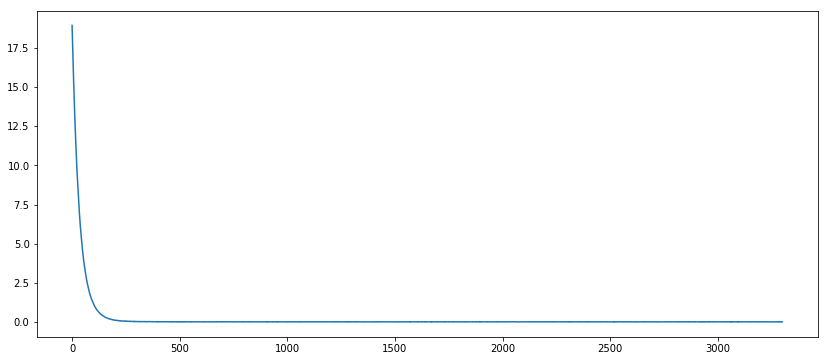

In [88]:
plt.plot(costs)
plt.show()

In [89]:
for i in p:
    print(i)

[ 0.57143629  0.56384337  0.51329488  0.46023712  0.43971658  0.39717278
  0.41196278  0.34430429  0.37299696  0.35215595  0.32043886  0.35965782
  0.34075549  0.37102968  0.36023387  0.35845229  0.31609857  0.29257354
  0.30519202  0.30610257  0.27881485  0.26856369  0.28371641  0.25287187
  0.20187464  0.20817378  0.20993079  0.20352656  0.22496001  0.25438344
  0.28589544  0.25408974  0.26709265  0.26398781  0.23523089  0.24086308
  0.23927125  0.25100636  0.22727036  0.25733647  0.28489748  0.27922943
  0.28027666  0.30811602  0.26588047  0.25980788  0.24544972  0.27029708
  0.28133041  0.23856062  0.23035344  0.22333647  0.24351351  0.25917253
  0.28113142  0.24472037  0.24750589  0.24239269  0.26894426  0.26775053
  0.28832912  0.30945301  0.32131568  0.31258208  0.36676067  0.35291627
  0.34163067  0.32873392  0.33308446  0.35531205  0.35999948  0.36022833
  0.37289548  0.35404581  0.35627335  0.37950987  0.38830435  0.37822193
  0.36001948  0.34911379  0.34300634  0.32437831  0

In [90]:
print((1 - np.count_nonzero(p)/np.size(p))*100,"%  \'0\' values in prediction")

0.0 %  '0' values in prediction


In [91]:
for i in batch_x:
    print(i)

[ 0.87621061  0.88589477  0.80884214  0.6665263   0.66021055  0.54315796
  0.57852638  0.52336844  0.53305261  0.48799998  0.46357892  0.50736844
  0.40968427  0.42989475  0.42905265  0.40736844  0.38947366  0.32631576
  0.34442107  0.35578949  0.32715791  0.30736843  0.2867369   0.25052633
  0.21431576  0.1924211   0.18021053  0.17768422  0.1911579   0.19705264
  0.29642107  0.23326317  0.24968422  0.2543158   0.24463163  0.25389475
  0.2530526   0.27536843  0.21621049  0.20926317  0.22147365  0.3162105
  0.32000001  0.32631576  0.25978944  0.23284212  0.20168422  0.23578948
  0.24505268  0.18694738  0.16336843  0.16547369  0.17136847  0.16168418
  0.19157896  0.19494738  0.20252637  0.17642106  0.2138947   0.21094734
  0.20673681  0.26568426  0.2530526   0.26863159  0.32252629  0.26947374
  0.27452633  0.27410523  0.25684212  0.30105269  0.27031576  0.27157896
  0.30063163  0.279579    0.27578949  0.29810523  0.33052633  0.32084212
  0.30063163  0.28000005  0.2627369   0.24547365  0.

In [92]:
for i in p:
    print(i)

[ 0.57143629  0.56384337  0.51329488  0.46023712  0.43971658  0.39717278
  0.41196278  0.34430429  0.37299696  0.35215595  0.32043886  0.35965782
  0.34075549  0.37102968  0.36023387  0.35845229  0.31609857  0.29257354
  0.30519202  0.30610257  0.27881485  0.26856369  0.28371641  0.25287187
  0.20187464  0.20817378  0.20993079  0.20352656  0.22496001  0.25438344
  0.28589544  0.25408974  0.26709265  0.26398781  0.23523089  0.24086308
  0.23927125  0.25100636  0.22727036  0.25733647  0.28489748  0.27922943
  0.28027666  0.30811602  0.26588047  0.25980788  0.24544972  0.27029708
  0.28133041  0.23856062  0.23035344  0.22333647  0.24351351  0.25917253
  0.28113142  0.24472037  0.24750589  0.24239269  0.26894426  0.26775053
  0.28832912  0.30945301  0.32131568  0.31258208  0.36676067  0.35291627
  0.34163067  0.32873392  0.33308446  0.35531205  0.35999948  0.36022833
  0.37289548  0.35404581  0.35627335  0.37950987  0.38830435  0.37822193
  0.36001948  0.34911379  0.34300634  0.32437831  0

[ 0.5715344   0.56393641  0.51343697  0.46034041  0.43979067  0.39712995
  0.41200191  0.34434259  0.37315291  0.35229179  0.32051063  0.35973135
  0.34085363  0.37112162  0.36031809  0.35854039  0.31622037  0.29267222
  0.30535769  0.30626893  0.27894992  0.26872247  0.2838501   0.25300258
  0.20201358  0.20826603  0.21002209  0.20352426  0.22493441  0.2543593
  0.28590637  0.25415048  0.26713112  0.2641103   0.23538576  0.24100764
  0.23944151  0.25118199  0.22746041  0.25750163  0.28512681  0.27942982
  0.28049359  0.30841461  0.26612818  0.2600446   0.24567705  0.27057782
  0.28159279  0.23881772  0.2306128   0.22362655  0.24385814  0.2595498
  0.28153187  0.24506325  0.24788827  0.24267423  0.26925635  0.26806346
  0.28867596  0.30979383  0.32172745  0.31299186  0.3672204   0.35334325
  0.34206173  0.32908615  0.33350003  0.35576546  0.36043721  0.36064336
  0.37338293  0.35461897  0.356805    0.38009456  0.38888687  0.37883547
  0.36061573  0.34967729  0.34353948  0.32486865  0.3

In [93]:
diff = abs(p - batch_x)

In [94]:
for i in diff:
    print(i)

[ 0.30477432  0.3220514   0.29554726  0.20628919  0.22049398  0.14598518
  0.1665636   0.17906415  0.16005566  0.13584402  0.14314006  0.14771062
  0.06892878  0.05886508  0.06881878  0.04891615  0.07337509  0.03374222
  0.03922904  0.04968691  0.04834306  0.03880475  0.00302049  0.00234554
  0.01244111  0.01575268  0.02972026  0.02584234  0.03380211  0.0573308
  0.01052563  0.02082658  0.01740842  0.00967201  0.00940074  0.01303166
  0.01378135  0.02436207  0.01105987  0.0480733   0.06342383  0.03698107
  0.03972336  0.01819974  0.00609102  0.02696577  0.0437655   0.0345076
  0.03627772  0.05161324  0.06698502  0.05786278  0.07214504  0.09748835
  0.08955246  0.04977299  0.04497952  0.06597163  0.05504956  0.0568032
  0.08159232  0.04376875  0.06826308  0.04395049  0.04423438  0.08344253
  0.06710434  0.05462869  0.07624235  0.05425936  0.08968372  0.08864937
  0.07226385  0.07446681  0.08048387  0.08140463  0.05777802  0.05737981
  0.05938784  0.06911374  0.08026945  0.07890466  0.07

In [95]:
print('average error in our case = ',np.mean(diff))

average error in our case =  0.192312112698


In [96]:
random = np.random.uniform(0,1,(10,503))

In [97]:
diff_random = abs(batch_x - random)
print('average error in a random case = ',np.mean(diff_random))

average error in a random case =  0.323914541783
